In [1]:
import numpy as np
from scipy.stats.stats import pearsonr
import astropy.units as u
import matplotlib.pyplot as plt
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation, AltAz
from astropy.coordinates import ICRS, Galactic, FK4, FK5 

from os.path import exists 

#Using latex rendering:
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)


/opt/python/2.7.10/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [3]:
nchan = 32
tele1 = 'ef'
tele2 = 'jb'
time_string1 = '2015-10-19T00:17:47.415' # S/N = 89!, main pulse 

p1 = np.load('/mnt/raid-cita/ramain/GPs/GP%s/p%s.npy' % (tele1, time_string1))
p2 = np.load('/mnt/raid-cita/ramain/GPs/GP%s/p%s.npy' % (tele2, time_string1))


plt.plot(abs(p1).sum(-1).sum(-1))
plt.plot(abs(p2).sum(-1).sum(-1))
plt.show()

p1R = p1[...,0]
p2R = p2[...,0]


In [35]:
p1ts = np.fft.irfft(p1R, axis=1).ravel()
p2ts = np.fft.irfft(p2R, axis=1).ravel()


print(p1ts.shape)

(16384,)


Populating the interactive namespace from numpy and matplotlib


(8200, 8700)

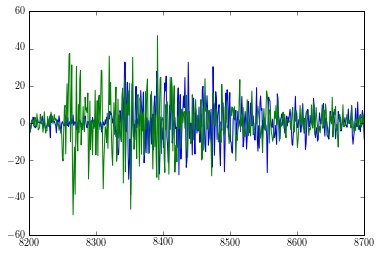

In [36]:
%pylab inline
plot(p1ts)
plot(p2ts)
xlim(8200,8700)

0.892203180828


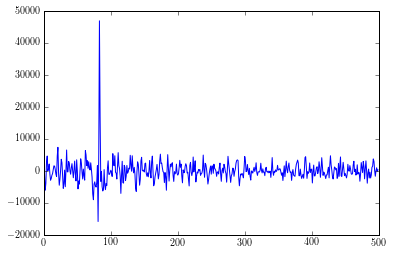

In [37]:
corr = np.fft.irfft( np.fft.rfft(p1ts[8200:8700]) * np.fft.rfft(p2ts[8200:8700]).conj() )

c1 = np.fft.irfft( np.fft.rfft(p1ts[8200:8700]) * np.fft.rfft(p1ts[8200:8700]).conj() )
c2 = np.fft.irfft( np.fft.rfft(p2ts[8200:8700]) * np.fft.rfft(p2ts[8200:8700]).conj() )

crosscorr = max(corr) / np.sqrt(max(c1) * max(c2))

print crosscorr
plt.plot(corr)
# plt.xlim(-100,100)
plt.show()

0.28919351862024334

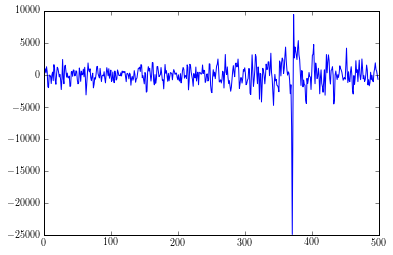

In [42]:
def find_cross_corr(time_string,tele1,tele2):
    '''Takes in the time_string, 2 telescope strings and returns the cross_corr'''
    p1 = np.load('/mnt/raid-cita/ramain/GPs/GP%s/p%s.npy' % (tele1, time_string))
    p2 = np.load('/mnt/raid-cita/ramain/GPs/GP%s/p%s.npy' % (tele2, time_string))
    channum = 0
    p1R = p1[...,channum] #p1 has shape (64,129,16)
    p2R = p2[...,channum]
    p1ts = np.fft.irfft(p1R,axis = 1).ravel() #fft into time domain, now p1ts is raw signal
    p2ts = np.fft.irfft(p2R,axis = 1).ravel() 
    corr = np.fft.irfft( np.fft.rfft(p1ts[8200:8700]) * np.fft.rfft(p2ts[8200:8700]).conj() ) #pulse width
    c1 = np.fft.irfft( np.fft.rfft(p1ts[8200:8700]) * np.fft.rfft(p1ts[8200:8700]).conj() )
    c2 = np.fft.irfft( np.fft.rfft(p2ts[8200:8700]) * np.fft.rfft(p2ts[8200:8700]).conj() )
    crosscorr = max(corr) / np.sqrt(max(c1) * max(c2))
    plot(corr)
    return crosscorr

find_cross_corr(time_string1,'bd','ef')

In [2]:
def find_distance(pos1,pos2):
    '''Returns the distance of 2 positions in km'''
    return sqrt((pos1.x-pos2.x)**2+(pos1.y-pos2.y)**2+(pos1.z-pos2.z)**2).to(u.km).value


def find_EW_NS_positions(pos1,pos2):
    '''Returns the distance along EW and along NS as a tuple value'''
    R = 6371 #earth's radius in km
    dtheta = pos1.longitude.value-pos2.longitude.value #in degrees
    phi = (90-abs(pos1.latitude.value)+90-abs(pos2.latitude.value))/2.
    EW = abs(2.*R*sin(deg2rad(dtheta)/2.)*sin(deg2rad(phi)))
    NS = abs(pos1.z.value-pos2.z.value)/1000.
    return EW,NS

obspos = {'ef': EarthLocation(4033947.2616*u.m, 486990.7866*u.m, 4900430.9915*u.m),
         'wb': EarthLocation(3828763.6100*u.m, 442448.8200*u.m, 5064923.0800*u.m),
         'jb': EarthLocation(3822626.0400*u.m, -154105.6500*u.m, 5086486.0400*u.m),
         'sr': EarthLocation(4864197.4692*u.m, 792184.8623*u.m, 4035367.1273*u.m),
         'tr': EarthLocation(3638558.5100*u.m, 1221969.7200*u.m, 5077036.7600*u.m),
         'o8': EarthLocation(3370965.9090*u.m, 711466.1978*u.m, 5349664.1947*u.m),
         'hh': EarthLocation(5083275.3295*u.m, 2668779.2123*u.m, -2769143.9034*u.m),
         'bd': EarthLocation(-839566.7739*u.m, -3866810.1085*u.m, 4985708.7210*u.m)
         }


In [8]:
# from process_frequency import obspos,find_distance
'''Does not work right now because of errors in process_freq'''

'Does not work right now because of errors in process_freq'

In [3]:
'''Getting cross correlation coefficient vs telescope distance plot'''
teles = ['jb','ef','hh','wb','o8','tr','sr','bd']
N = 16
D = {}
nchan = 512
for i,tele1 in enumerate(teles):
    for j,tele2 in enumerate(teles[i+1:]):
        cc = find_cross_corr(time_string1,tele1,tele2)
        D[find_distance(obspos[tele1],obspos[tele2]),cc] = ( tele1+'-'+tele2)
print D
xlabel('time lag')
ylabel('Convolution peak')
title('Convoluting the voltage signal of the brightest peaks across pairs of telescopes. \n (Each color represents a pair of telescope)')

NameError: name 'find_cross_corr' is not defined

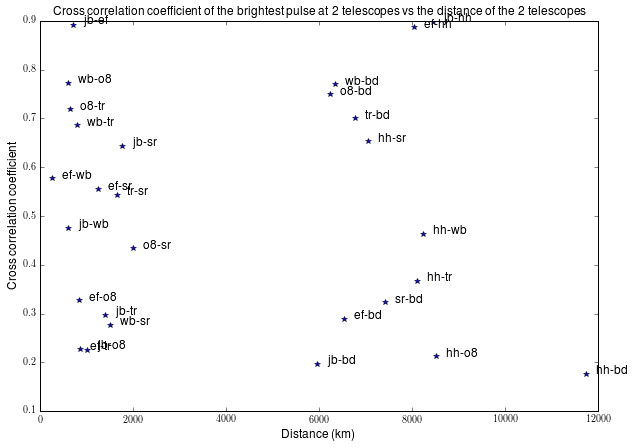

In [41]:
distances,cvalues = zip(*D.keys())
figure(figsize = (10,7))
plot(distances,cvalues,'*')
xlabel('Distance (km)',fontsize = 12)
ylabel('Cross correlation coefficient',fontsize = 12)
for i in range(len(distances)):
    annotate(D[distances[i],cvalues[i]],(distances[i],cvalues[i]),xytext = (10, 0),textcoords = 'offset points',fontsize = 12)
title('Cross correlation coefficient of the brightest pulse at 2 telescopes vs the distance of the 2 telescopes',fontsize = 12)

{0.26281213912193474: 'ef-sr', 0.86936265568702276: 'ef-hh', 0.60180807515325441: 'ef-o8', 0.46974787329024376: 'ef-tr', 0.28771600446554718: 'o8-tr', 0.36468599762831561: 'sr-bd', 0.29874799379240913: 'hh-wb', 0.56766857994945719: 'ef-bd', 0.53051515251693404: 'jb-o8', 0.54423370147968608: 'wb-sr', 0.22588314680265437: 'hh-sr', 0.40016107025162045: 'jb-wb', 0.27961389541325343: 'wb-o8', 0.624026923781272: 'wb-tr', 0.63497081439821623: 'hh-o8', 0.53139850579262682: 'hh-bd', 0.83863350881611931: 'jb-hh', 0.40574042757220768: 'tr-sr', 0.42933644176842534: 'hh-tr', 0.87010172859183021: 'jb-ef', 0.55219570896544667: 'jb-tr', 0.52715871865730801: 'tr-bd', 0.58325092457727035: 'wb-bd', 0.27567132694435609: 'o8-bd', 0.36988722979659183: 'jb-sr', 0.27076448467191078: 'ef-wb', 0.56234722873659293: 'jb-bd', 0.3278717397443367: 'o8-sr'}


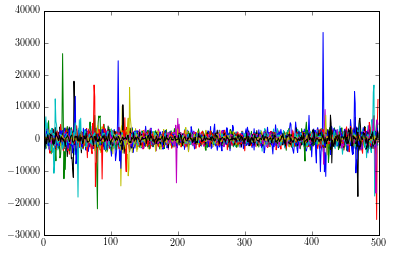

In [26]:
teles = ['jb','ef','hh','wb','o8','tr','sr','bd']
N = 16
D = {}
EWs = []
NSs = []
coercoeff = []
nchan = 512
for i,tele1 in enumerate(teles):
    for j,tele2 in enumerate(teles[i+1:]):
        cc = find_cross_corr(time_string1,tele1,tele2)
        EWs.append(find_EW_NS_positions(obspos[tele1],obspos[tele2])[0])
        NSs.append(find_EW_NS_positions(obspos[tele1],obspos[tele2])[1])
        coercoeff.append(cc)
        D[cc] = (tele1+'-'+tele2)
# print EWs
# print NSs
print D

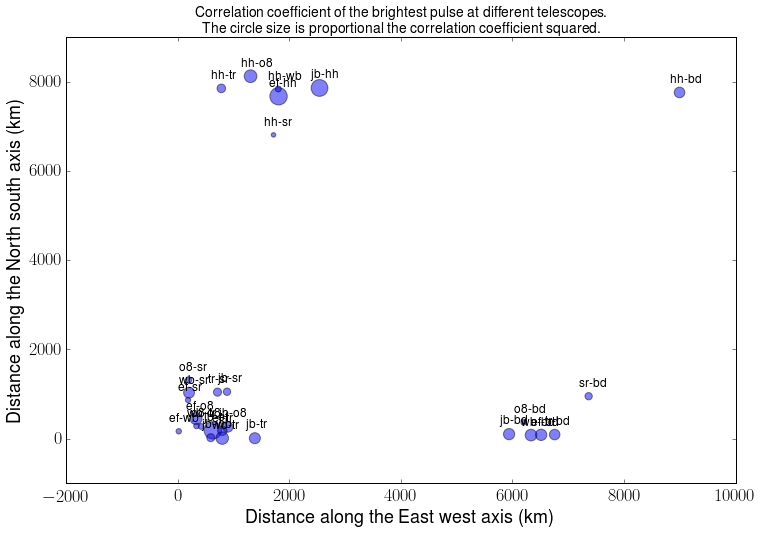

In [28]:
figure(figsize = (12,8))
circle_sizescc = [cir**2*400. for cir in coercoeff]
scatter(EWs,NSs,s=circle_sizescc,alpha = 0.5)
xlabel('Distance along the East west axis (km)',fontsize = 18)
ylabel('Distance along the North south axis (km)',fontsize = 18)
tick_params(axis='both', which='major', labelsize=18)
for i in range(len(circle_sizescc)):
    annotate(D[coercoeff[i]],zip(EWs,NSs)[i],xytext = (-10, 10),textcoords = 'offset points',fontsize = 12)
title('Correlation coefficient of the brightest pulse at different telescopes. \nThe circle size is proportional the correlation coefficient squared.',
     fontsize = 14)
show()

In [11]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy
